In [ ]:
#| default_exp datasets

In [ ]:
#|export
from __future__ import annotations
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F

from datasets import load_dataset,load_dataset_builder

In [ ]:
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

In [ ]:
import logging
logging.disable(logging.WARNING)

## Hugging Face Datasets

`dataset_builder` has meta data on the dataset

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [ ]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, dataset_name='fashion_mnist')}

No we download the dataset itself

In [ ]:
dsd = load_dataset(name)
# Downloading and preparing dataset fashion_mnist/fashion_mnist to /home/vtec/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1
dsd

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

We get a train and a test dataset

In [ ]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

Each dataset has a property `features` returning a dictionary:

In [ ]:
train.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

keys/values: 
- `image`: `PIL` images
- `label`: labels

In [ ]:
# alias x and y for image and label
x, y = ds_builder.info.features.keys()

`dataset[index]['image]` same as `dataset[index][x]` return a list of images

In [ ]:
x,y = ds_builder.info.features

In [ ]:
x,y

('image', 'label')

In [ ]:
img = train[0][x]
img

In [ ]:
xb = train[:5][x]
for img in xb:
    display(img)

`dataset[index]['label]` same as `dataset[index][y]` returns a list of labels as integers

In [ ]:
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

We can convert the `int` into text labels

In [ ]:
train.features[y].int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [ ]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [ ]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [ ]:
train[y][:5]

[9, 0, 0, 3, 0]

HF often returns dictionaries and not tuple for the elements of a dataset. PyTorch can work with both. So our collate function will return a dict of 2 tensors

In [ ]:
TF

<module 'torchvision.transforms.functional' from '/home/vtec/miniconda3/envs/course22p2/lib/python3.10/site-packages/torchvision/transforms/functional.py'>

In [ ]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}

Function turns a list of single image tensors into one batch image tensor

In [ ]:
print(TF.to_tensor(train[0][x]).shape)
print(torch.stack([TF.to_tensor(img) for img in train[:5][x]]).shape)

torch.Size([1, 28, 28])
torch.Size([5, 1, 28, 28])


Also, we are not using transforms, ... but we put the entire pipeline in the `collate_fn`

In [ ]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

But we also could use a transform to make this more "abstracted"

`train.with_transform(transform_fctn)` will take the dataset train (each element `b`) and transforms it according to the `transform_fctn`. `b` is a dictionary, in our case with keys `image` and `label`

It expect the `transform_fctn` to return the transformed `b`. 

In our dataset, the labels are formatted as we want, but the images are `PIL` images and we want to get tensors. The transform will do that for us (modifying `b[x]`). Then we return the modified `b`

In [ ]:
# TF.to_tensor?

In [ ]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [ ]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b.keys(), b[x].shape, b[y]

(dict_keys(['image', 'label']),
 torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

Explanation of this in the lesson video [here](https://youtu.be/DYdvnzRk7Vs?t=5001)

Jeremy Howard prefers to just write a function where we only transform and then use a decorator to wrap the function into a function that will return the b

In [ ]:
# Just the transform, then in next cell, the wrapping
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [ ]:
transformi = inplace(_transformi)

In [ ]:
r = train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

Same using decorator

In [ ]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

Let's make things more automatic, with python `itemgetter`.

`itemgetter` is a function that returns a function, which will return the values for specified keys in a dictionary or something that looks like a dictionary.

In the following example, we create a function `ig` which will return the values for keys `a` and `c` from the dictionary, and just disregards any other key

In [ ]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')
ig(d)

(1, 3)

We can create our own class that looks like a dictionary to Python, i.e. it acts like a `dict` when `__getitem__` is called.

In [ ]:
class D:
    def __getitem__(self, k): 
        return 1 if k=='a' else 2 if k=='b' else 3

In [ ]:
d = D()
ig(d)

(1, 3)

Now let's use this to our advantage.

In [ ]:
list(tdsf.features)

['image', 'label']

PyTorch has a default collate function `default_collate` that brings together values with the same keys in a dictionary. It also can work with tuple, following the hierarchy of the tuple

In [ ]:
batch = dict(a=[1],b=[2], c=[10]), dict(a=[3],b=[4], c=[20])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])], 'c': [tensor([10, 20])]}

In [ ]:
batch = tuple(((1,2,10), (3, 4, 20)))
default_collate(batch)

[tensor([1, 3]), tensor([2, 4]), tensor([10, 20])]

Now we can create a collate function `collate_dict` that will:
- take a dataset ds (dict type), 
- create a itemgetter for all the keys in the dataset.features and returns a group of tuples instead of dict
- apply this itemgetter get the data returned from the `default_collate` which is a dict, to convert it into a tuple

In [ ]:
#|export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [ ]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

Very good to convert from dict to tuples and vice versa. HF 

## Plotting images

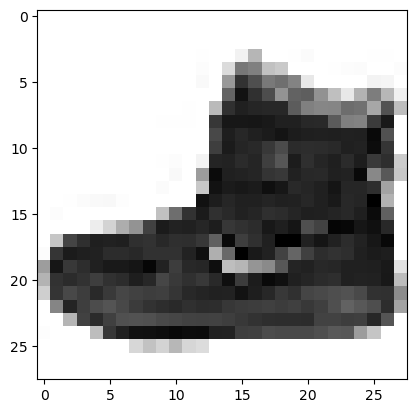

In [ ]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);

In [ ]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # change the dimension orders to match what matplotlig expect (channels last, not first)
    if fc.hasattrs(im, ('cpu','permute')):
        im = im.cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    # handle black and white images    
    if im.shape[-1]==1: im=im[...,0]
    # matplotlibs options
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

We passed `**kwargs` to the function, and also used `@fastcore.delegates(plt.Axes.imshow)` to also get the help from matplotlib

In [ ]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



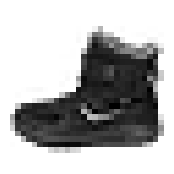

In [ ]:
show_image(img, figsize=(2,2));

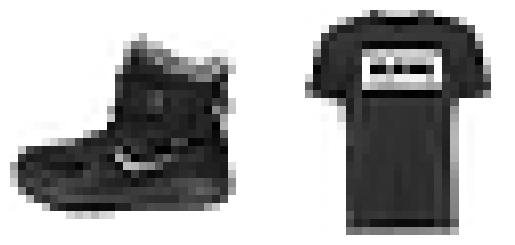

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2)
show_image(img, axs[0])
show_image(xb[1], axs[1]);

In [ ]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

In [ ]:
from nbdev.showdoc import show_doc

In [ ]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                subplot_kw=None, gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

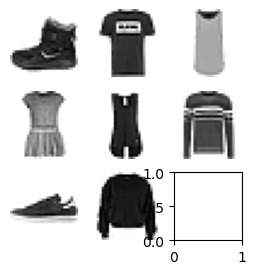

In [ ]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [ ]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.ceil(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

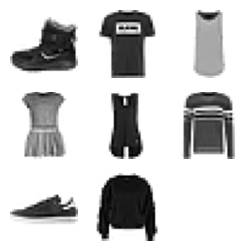

In [ ]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [ ]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int=1, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [ ]:
yb = b['label']
lbls = yb[:8]

In [ ]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

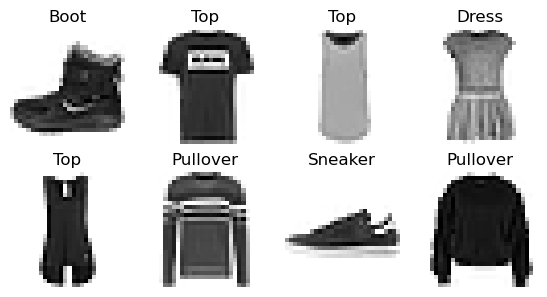

In [ ]:
show_images(imgs, imsize=1.7, titles=titles)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()